In [140]:
import numpy as np
import cv2
import os
from tensorflow import keras
from tensorflow.keras import models, layers, Sequential
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import tqdm
import tensorflow as tf
import re
import json
import gdown
from sklearn.cluster import DBSCAN

In [47]:
# Load TuSimple dataset
dataset = kagglehub.dataset_download('gjeevanm/object-detection-dataset')


In [43]:
train_path = dataset + '/tusimple_preprocessed/training'
frames = dataset + '/tusimple_preprocessed/training/frames'
lane_masks  = dataset + '/tusimple_preprocessed/training/lane-masks'


In [83]:
# Create a generator and get the images from the directory
img_generator = keras.preprocessing.image.ImageDataGenerator()
seed = 10
images_set = img_generator.flow_from_directory(
    train_path,
    shuffle=False,
    batch_size=64,
    class_mode='binary',
    target_size=(256, 320)
)
images, labels = next(images_set)

Found 7252 images belonging to 2 classes.


In [49]:
# Current Directory
current_dir = os.getcwd()
working_dir = os.path.join(current_dir, 'lane_detection')
image_dir = os.path.join(working_dir, 'images')
os.makedirs(working_dir, exist_ok=True)
os.makedirs(image_dir, exist_ok=True)
# Save few files to local
images, labels = next(images_set)
np.save(working_dir + '/images.npy', images)
np.save(working_dir + '/labels.npy', labels)
# Save 5 images to local
for i in range(5):
    cv2.imwrite(image_dir + f'/image_{i}.jpg', images[i])


# **EDA**

# Visualize Images and Lane Masks


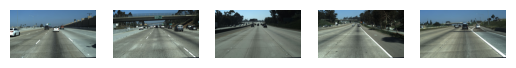

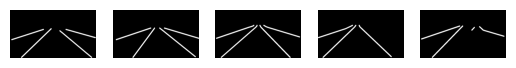

In [50]:
for i, filename in enumerate(os.listdir(frames)[:5]):
    img_path = os.path.join(frames, filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()


# Visualize top 5 masks
for i, filename in enumerate(os.listdir(lane_masks)[:5]):
    img_path = os.path.join(lane_masks, filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [51]:
print(f"Shape of images: {images.shape}")
print(f"Shape of labels: {labels.shape}")

Shape of images: (64, 256, 320, 3)
Shape of labels: (64,)


In [52]:
def display_image_statistics(images):
    print(f"Min pixel value: {images.min()}")
    print(f"Max pixel value: {images.max()}")
    print(f"Mean pixel value: {images.mean()}")
    print(f"Standard deviation of pixel values: {images.std()}")

display_image_statistics(images)

Min pixel value: 0.0
Max pixel value: 255.0
Mean pixel value: 97.54496002197266
Standard deviation of pixel values: 54.98300552368164


# Class Distribution

Found 7252 images belonging to 2 classes.


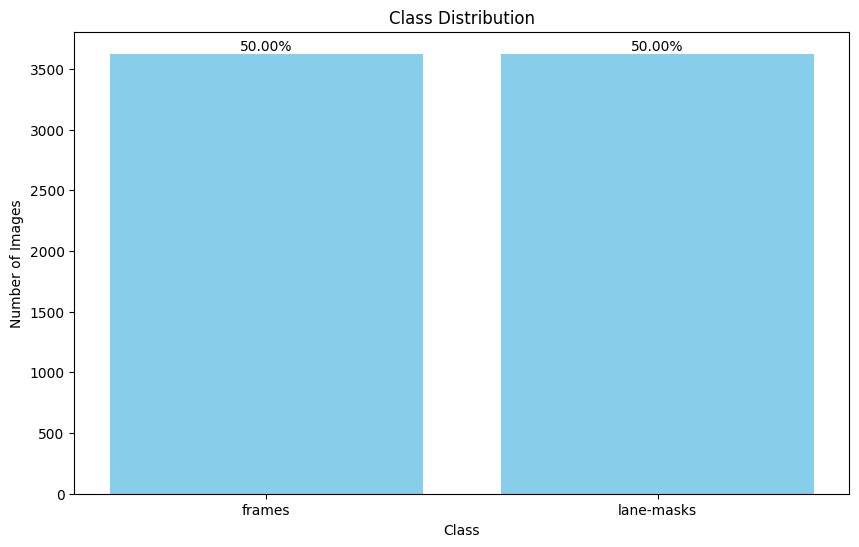

Class Counts: Counter({0: 3626, 1: 3626})
Total Images: 7252
Image shapes (first batch):
Counter({(256, 320, 3): 64})


In [16]:
img_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

def analyze_image_data(train_path, target_size=(256,320)):
    try:
      images_set = img_generator.flow_from_directory(
          train_path,
          shuffle=False,
          batch_size=64,
          class_mode='binary',
          target_size=target_size
      )

      # Extract class distribution from the ImageDataGenerator object
      class_counts = Counter(images_set.classes)
      class_labels = list(images_set.class_indices.keys())
      total_images = sum(class_counts.values())

      # Enhanced Class Distribution Plot
      plt.figure(figsize=(10, 6))
      plt.bar(class_labels, class_counts.values(), color='skyblue')
      plt.title("Class Distribution")
      plt.xlabel("Class")
      plt.ylabel("Number of Images")
      for i, count in enumerate(class_counts.values()):
          percentage = (count / total_images) * 100
          plt.text(i, count, f"{percentage:.2f}%", ha='center', va='bottom')
      plt.show()


      print(f"Class Counts: {class_counts}")
      print(f"Total Images: {total_images}")

      # Image Shape Analysis
      img_shapes = [img.shape for img in images]
      print(f"Image shapes (first batch):\n{Counter(img_shapes)}")

    except Exception as e:
        print(f"Error during EDA: {e}")

analyze_image_data(train_path)

# Data augmentation

Found 7252 images belonging to 2 classes.


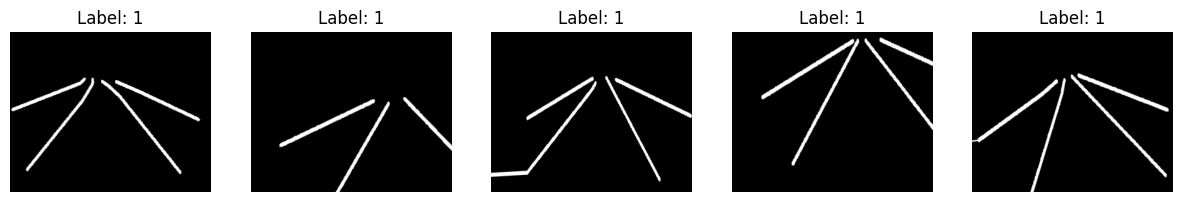

In [17]:
data_gen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize images to [0, 1]
    rotation_range=20,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,  # Apply shear transformations
    zoom_range=0.2,  # Randomly zoom in
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill pixels after transformations
)

# Apply the generator to the training directory
augmented_generator = data_gen.flow_from_directory(
    train_path,
    target_size=(256, 320),
    batch_size=64,
    class_mode='binary'
)

# Display augmented images for verification
def visualize_augmented_images(generator, num_images=5):
    images, labels = next(generator)
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_augmented_images(augmented_generator)

# Pixel Distribution

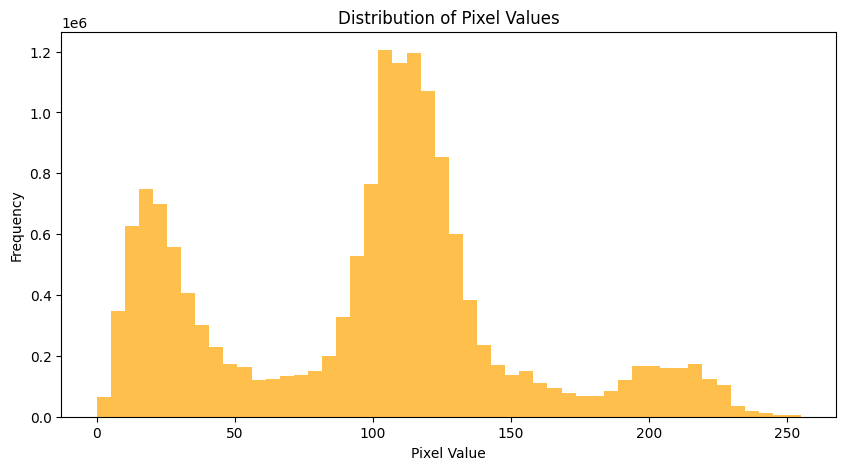

In [18]:
def visualize_image_distribution(images):
    plt.figure(figsize=(10, 5))
    plt.hist(images.ravel(), bins=50, color='orange', alpha=0.7)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Pixel Values')
    plt.show()

visualize_image_distribution(images)

# Preprocessing

# Gray Scale

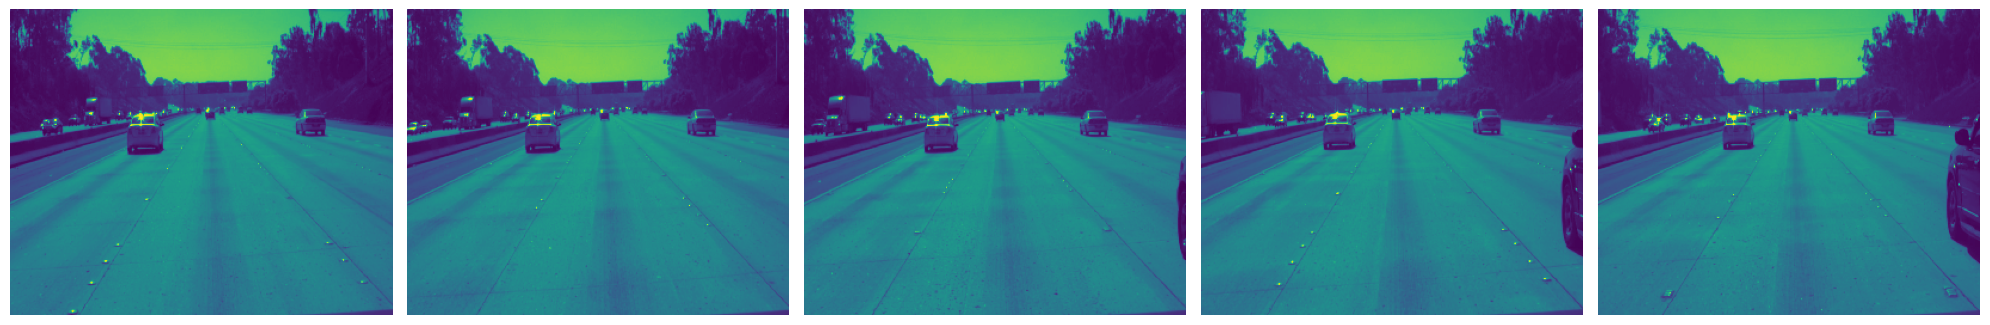

In [53]:
def convert_to_grayscale(images):
    grayscale_images = []
    for image in images:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        grayscale_images.append(gray_image)
    return np.array(grayscale_images)

grayscale_images = convert_to_grayscale(images)
plot_images(grayscale_images[:5])


# Gaussian Blur and Canny

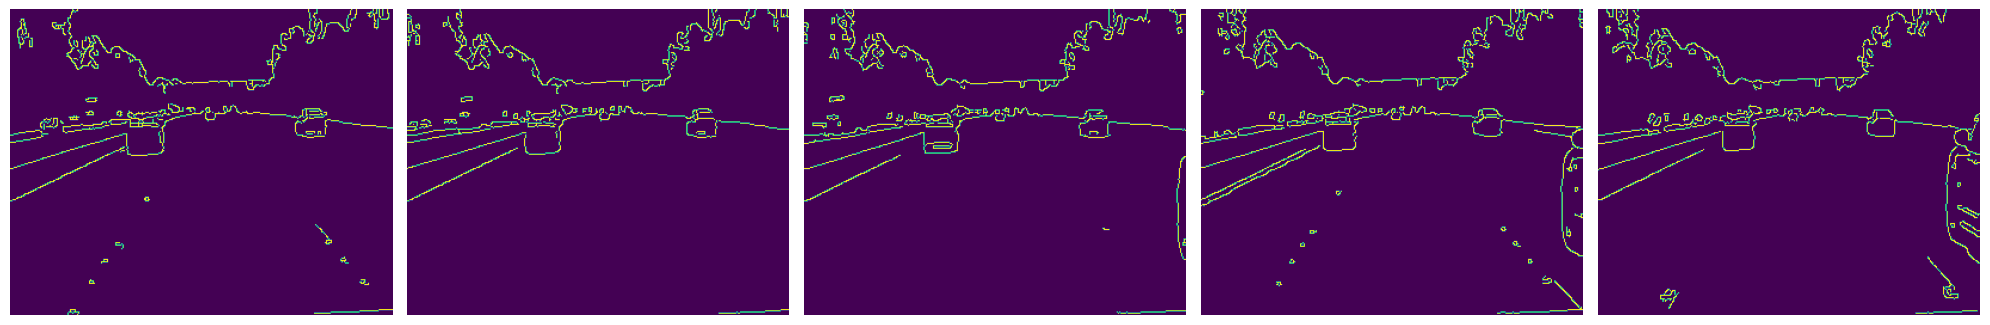

In [54]:
def apply_gaussian_canny(images):
    canny_images = []
    for image in images:
        image = (image * 255).astype(np.uint8)
        blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
        canny_image = cv2.Canny(blurred_image, 50, 150)
        canny_images.append(canny_image)
    return np.array(canny_images)

canny_images = apply_gaussian_canny(images)
plot_images(canny_images[:5])

# Region of Interest

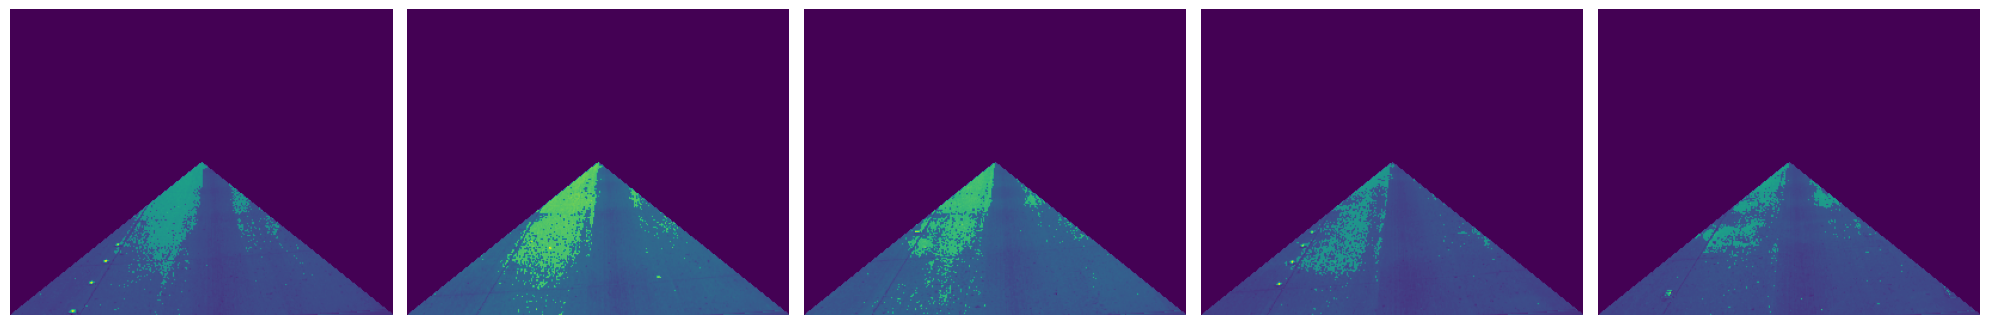

In [55]:

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)

    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def convert_to_grayscale(images):
    grayscale_images = []
    for image in images:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        grayscale_images.append(gray_image)
    return np.array(grayscale_images)

height, width = images[0].shape[:2]
vertices = np.array([[(0, height), (width / 2, height / 2), (width, height)]], dtype=np.int32)

grayscale_images = convert_to_grayscale(images)

roi_images = []
for image in grayscale_images:
    roi_image = region_of_interest(image, vertices)
    roi_images.append(roi_image)
roi_images = np.array(roi_images)

# Plot the ROI images
plot_images(roi_images[:5])

# Hough Line Transform

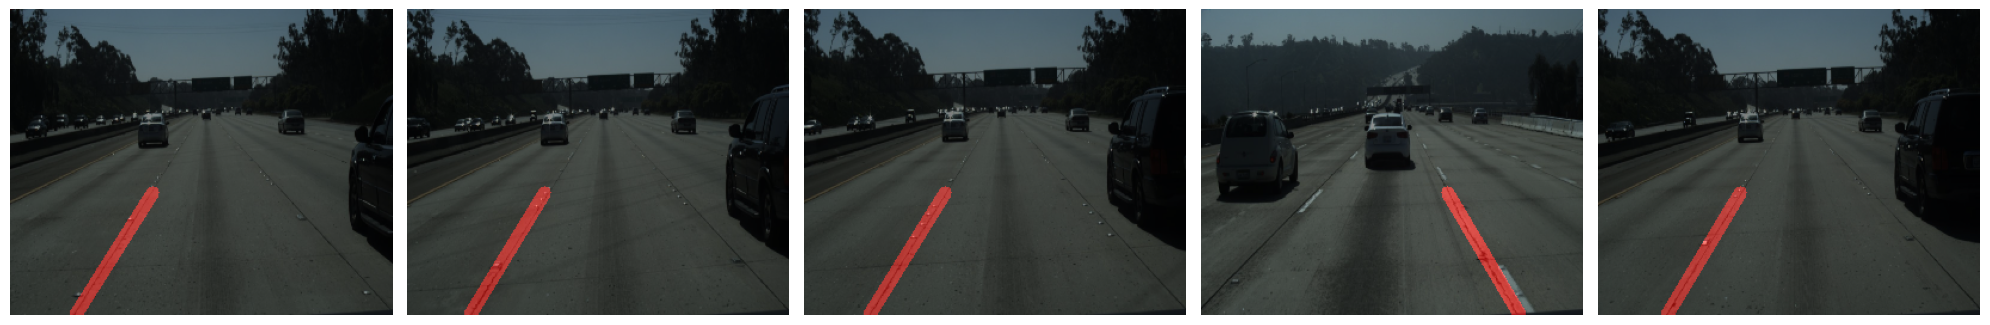

In [90]:
def process_and_draw_lanes(images):
    def region_selection(image):
        mask = np.zeros_like(image)
        ignore_mask_color = 255

        rows, cols = image.shape[:2]
        bottom_left = [cols * 0.1, rows * 0.95]
        top_left = [cols * 0.4, rows * 0.6]
        bottom_right = [cols * 0.9, rows * 0.95]
        top_right = [cols * 0.6, rows * 0.6]
        vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)

        cv2.fillPoly(mask, vertices, ignore_mask_color)
        masked_image = cv2.bitwise_and(image, mask)
        return masked_image

    def hough_transform(image):
        rho = 1
        theta = np.pi / 180
        threshold = 20
        min_line_length = 20
        max_line_gap = 300
        lines = cv2.HoughLinesP(
            image, rho, theta, threshold, minLineLength=min_line_length, maxLineGap=max_line_gap
        )
        return lines

    def draw_lines(image, lines):
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        return image

    def average_slope_intercept(lines):
        left_lines = []  # (slope, intercept)
        left_weights = []  # (length,)
        right_lines = []  # (slope, intercept)
        right_weights = []  # (length,)

        for line in lines:
            for x1, y1, x2, y2 in line:
                if x1 == x2:
                    continue
                # calculating slope and intercept
                slope = (y2 - y1) / (x2 - x1)
                intercept = y1 - (slope * x1)
                length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))

                # left lane has negative slope and right lane has positive slope
                if slope < 0:
                    left_lines.append((slope, intercept))
                    left_weights.append(length)
                else:
                    right_lines.append((slope, intercept))
                    right_weights.append(length)

        left_lane = np.dot(left_weights, left_lines) / np.sum(left_weights) if len(left_weights) > 0 else None
        right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
        return left_lane, right_lane

    def pixel_points(y1, y2, line):
      if line is None:
          return None
      slope, intercept = line

      if abs(slope) < 1e-6:
          return None

      x1 = int((y1 - intercept) / slope)
      x2 = int((y2 - intercept) / slope)
      return ((x1, y1), (x2, y2))

    def lane_lines(image, lines):
        left_lane, right_lane = average_slope_intercept(lines)
        y1 = image.shape[0]
        y2 = int(y1 * 0.6)
        left_line = pixel_points(y1, y2, left_lane)
        right_line = pixel_points(y1, y2, right_lane)
        return left_line, right_line

    def draw_lane_lines(image, lines, color=(255, 0, 0), thickness=10):
        line_image = np.zeros_like(image)
        for line in lines:
            if line is not None:
                cv2.line(line_image, *line, color, thickness)
        return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)
    images_with_lanes = []

    for image in images:
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Apply Gaussian blur
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Apply Canny edge detection
        blurred1 = blurred.astype(np.uint8)
        edges = cv2.Canny(blurred1, 50, 150)

        # Select region of interest
        region = region_selection(edges)

        # Apply Hough Transform
        lines = hough_transform(region)

        # Draw lane lines
        if lines is not None:
            left_line, right_line = lane_lines(region, lines)
            image_with_lanes = draw_lane_lines(image, [left_line, right_line])
            images_with_lanes.append(image_with_lanes)


    return images_with_lanes

# Apply the function to the images
images_with_lanes = process_and_draw_lanes(images)

# Plot the first 10 images with lanes
def plot_images(images_arr, title=''):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        img_disp = img.astype(np.float32) / img.max()  # Normalize to [0, 1]

        ax.imshow(img_disp)
        ax.axis('off')
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

plot_images(images_with_lanes[:5])

# Model

# Model 1 - UNET

In [91]:

image_dir = dataset + '/tusimple_preprocessed/training/'+'frames'
mask_dir = dataset + '/tusimple_preprocessed/training/'+'lane-masks'

print("Actual frames contents:", os.listdir(image_dir)[:5])
print("Actual lane-masks contents:", os.listdir(mask_dir)[:5])

def load_data(image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []
    for img_name in sorted(os.listdir(image_dir)):
        if not img_name.endswith(('.jpg', '.png')):
            continue
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, target_size)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, target_size)
        image = image / 255.0
        mask = (mask > 128).astype(np.float32)  # Binarize mask
        images.append(image)
        masks.append(mask[..., np.newaxis])  # Add channel dimension

    # Check few files
    images = np.array(images)
    masks = np.array(masks)
    print("Images shape:", images.shape)
    print("Masks shape:", masks.shape)
    return images, masks

# load the data
images, masks = load_data(image_dir, mask_dir)

Actual frames contents: ['0313-2_4620.jpg', '0313-2_18660.jpg', '0313-1_12440.jpg', '0313-2_37660.jpg', '0313-2_240.jpg']
Actual lane-masks contents: ['0313-2_4620.jpg', '0313-2_18660.jpg', '0313-1_12440.jpg', '0313-2_37660.jpg', '0313-2_240.jpg']
Images shape: (3626, 256, 256, 3)
Masks shape: (3626, 256, 256, 1)


In [92]:
# Load the dataset
images, masks = load_data(image_dir, mask_dir)


Images shape: (3626, 256, 256, 3)
Masks shape: (3626, 256, 256, 1)


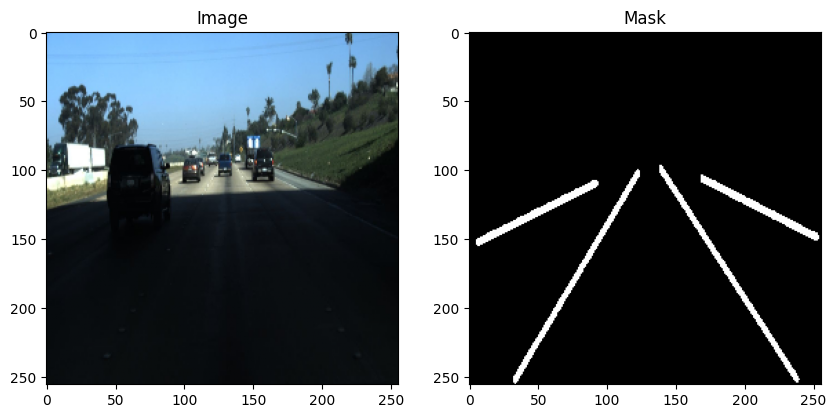

In [93]:
from sklearn.model_selection import train_test_split
train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)
import matplotlib.pyplot as plt

# Visualize a sample image and its mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(train_images[0])  # Display the first training image
plt.subplot(1, 2, 2)
plt.title('Mask')
plt.imshow(train_masks[0].squeeze(), cmap='gray')  # Display the corresponding mask
plt.show()


In [97]:
def build_unet(input_shape):
    inputs = tf.keras.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    return Model(inputs, outputs)

# Define and compile the model
input_shape = (256, 256, 3)
unet_model = build_unet(input_shape)
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = unet_model.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    batch_size=16, epochs=10
)


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.9572 - loss: 0.2132 - val_accuracy: 0.9629 - val_loss: 0.1151
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.9637 - loss: 0.1112 - val_accuracy: 0.9706 - val_loss: 0.0818
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.9704 - loss: 0.0816 - val_accuracy: 0.9723 - val_loss: 0.0746
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.9734 - loss: 0.0718 - val_accuracy: 0.9752 - val_loss: 0.0667
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.9754 - loss: 0.0646 - val_accuracy: 0.9767 - val_loss: 0.0620
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.9765 - loss: 0.0611 - val_accuracy: 0.9779 - val_loss: 0.0583
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.9774 - loss: 0.0587 - val_accuracy: 0.9782 - val_loss: 0.0562
Epoch 8/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.9782 - loss: 0.0557 - 

In [98]:
val_loss, val_accuracy = unet_model.evaluate(val_images, val_masks)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9790 - loss: 0.0540
Validation Loss: 0.05459157004952431
Validation Accuracy: 0.9786022305488586


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


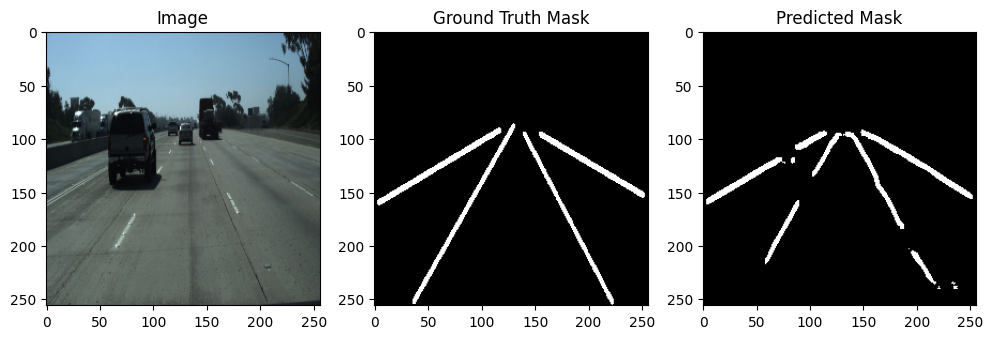

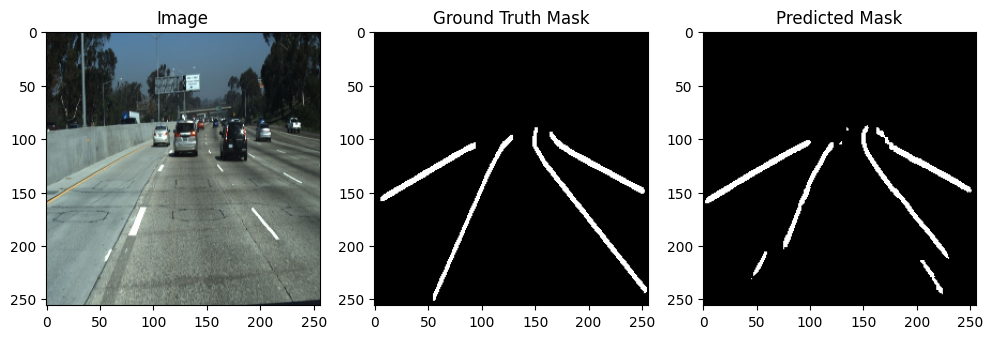

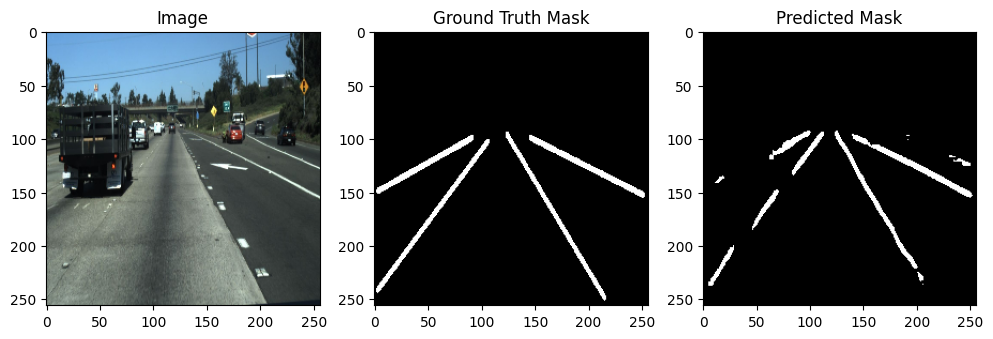

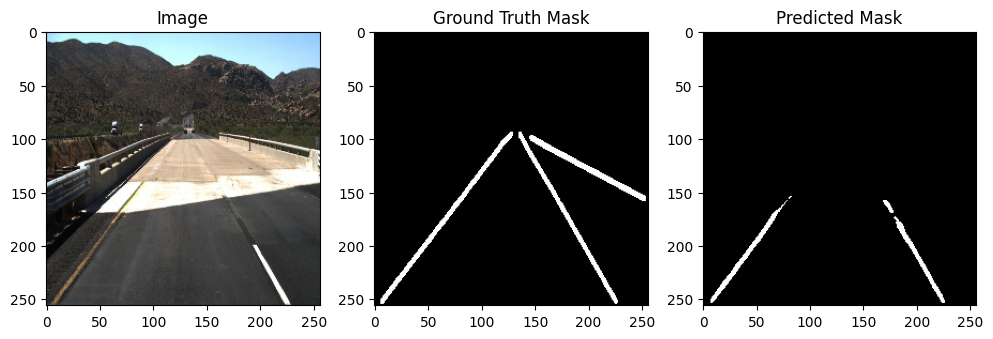

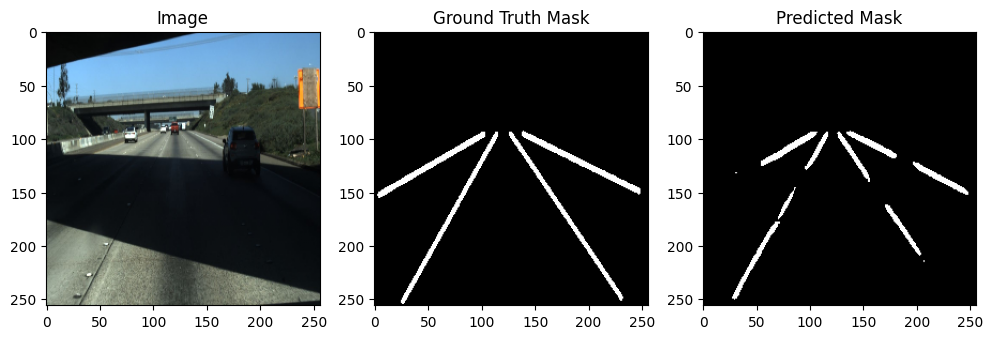

In [99]:
# Visualize predictions
preds = unet_model.predict(val_images[:5])  # Predict for the first 5 validation images
preds = (preds > 0.5).astype(np.uint8)  # Apply threshold to binarize predictions

import matplotlib.pyplot as plt
for i in range(5):
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(val_images[i])

    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.title('Ground Truth Mask')
    plt.imshow(val_masks[i].squeeze(), cmap='gray')

    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(preds[i].squeeze(), cmap='gray')

    plt.show()


# Model-2 E-Net

In [142]:

path = kagglehub.dataset_download("gjeevanm/tusimpledatawithconfig")


100%|██████████| 21.6G/21.6G [19:30<00:00, 19.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gjeevanm/tusimpledatawithconfig/versions/1


In [155]:
test_set = "/root/.cache/kagglehub/datasets/gjeevanm/tusimpledatawithconfig/versions/1/TUSimple/test_set"
train_set = "/root/.cache/kagglehub/datasets/gjeevanm/tusimpledatawithconfig/versions/1/TUSimple/train_set"
label = "/root/.cache/kagglehub/datasets/gjeevanm/tusimpledatawithconfig/versions/1/TUSimple/test_label.json"


In [156]:
class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path=train_set, train=True, size=(512, 256)):
        self._dataset_path = dataset_path
        self._mode = "train" if train else "eval"
        self._image_size = size # w, h


        if self._mode == "train":
            label_files = [
                os.path.join(self._dataset_path, f"label_data_{suffix}.json")
                for suffix in ("0313", "0531")
            ]
        elif self._mode == "eval":
            label_files = [
                os.path.join(self._dataset_path, f"label_data_{suffix}.json")
                for suffix in ("0601",)
            ]

        self._data = []

        for label_file in label_files:
            self._process_label_file(label_file)

    def __getitem__(self, idx):
        image_path = os.path.join(self._dataset_path, self._data[idx][0])
        image = cv2.imread(image_path)
        h, w, c = image.shape
        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image[..., None]
        lanes = self._data[idx][1]

        segmentation_image = self._draw(h, w, lanes, "segmentation")
        instance_image = self._draw(h, w, lanes, "instance")

        instance_image = instance_image[..., None]

        image = torch.from_numpy(image).float().permute((2, 0, 1))
        segmentation_image = torch.from_numpy(segmentation_image.copy())
        instance_image =  torch.from_numpy(instance_image.copy()).permute((2, 0, 1))
        segmentation_image = segmentation_image.to(torch.int64)

        return image, segmentation_image, instance_image # 1 x H x W [[0, 1], [2, 0]]

    def __len__(self):
        return len(self._data)

    def _draw(self, h, w, lanes, image_type):
        image = np.zeros((h, w), dtype=np.uint8)
        for i, lane in enumerate(lanes):
            color = 1 if image_type == "segmentation" else i + 1
            cv2.polylines(image, [lane], False, color, 10)

        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_NEAREST)

        return image

    def _process_label_file(self, file_path):
        with open(file_path) as f:
            for line in f:
                info = json.loads(line)
                image = info["raw_file"]
                lanes = info["lanes"]
                h_samples = info["h_samples"]
                lanes_coords = []
                for lane in lanes:
                    x = np.array([lane]).T
                    y = np.array([h_samples]).T
                    xy = np.hstack((x, y))
                    idx = np.where(xy[:, 0] > 0)
                    lane_coords = xy[idx]
                    lanes_coords.append(lane_coords)
                self._data.append((image, lanes_coords))

In [157]:
class InitialBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 1,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=bias)

        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)

        self.batch_norm = nn.BatchNorm2d(out_channels)

        self.out_activation = activation()

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        out = torch.cat((main, ext), 1)

        out = self.batch_norm(out)

        return self.out_activation(out)


class RegularBottleneck(nn.Module):
    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class DownsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        self.main_max1 = nn.MaxPool2d(
            2,
            stride=2,
            return_indices=return_indices)
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        self.out_activation = activation()

    def forward(self, x):
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        if main.is_cuda:
            padding = padding.cuda()


        main = torch.cat((main, padding), 1)


        out = main + ext

        return self.out_activation(out), max_indices


class UpsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU


        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)


        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation())

        # Transposed convolution
        self.ext_tconv1 = nn.ConvTranspose2d(
            internal_channels,
            internal_channels,
            kernel_size=2,
            stride=2,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        # 1x1 expansion convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x, max_indices, output_size):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class ENet(nn.Module):
    def __init__(self, binary_seg, embedding_dim, encoder_relu=False, decoder_relu=True):
        super(ENet, self).__init__()

        self.initial_block = InitialBlock(1, 16, relu=encoder_relu)

        # Stage 1 share
        self.downsample1_0 = DownsamplingBottleneck(16, 64, return_indices=True, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 share
        self.downsample2_0 = DownsamplingBottleneck(64, 128, return_indices=True, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # stage 3 binary
        self.regular_binary_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_binary_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # stage 3 embedding
        self.regular_embedding_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_embedding_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_embedding_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_bembedding_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # binary branch
        self.upsample_binary_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_binary_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.binary_transposed_conv = nn.ConvTranspose2d(16, binary_seg, kernel_size=3, stride=2, padding=1, bias=False)

        # embedding branch
        self.upsample_embedding_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_embedding_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.embedding_transposed_conv = nn.ConvTranspose2d(16, embedding_dim, kernel_size=3, stride=2, padding=1, bias=False)

    def forward(self, x):
        # Initial block
        input_size = x.size()
        x = self.initial_block(x)

        # Stage 1 share
        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 share
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # stage 3 binary
        x_binary = self.regular_binary_3_0(x)
        x_binary = self.dilated_binary_3_1(x_binary)
        x_binary = self.asymmetric_binary_3_2(x_binary)
        x_binary = self.dilated_binary_3_3(x_binary)
        x_binary = self.regular_binary_3_4(x_binary)
        x_binary = self.dilated_binary_3_5(x_binary)
        x_binary = self.asymmetric_binary_3_6(x_binary)
        x_binary = self.dilated_binary_3_7(x_binary)

        # stage 3 embedding
        x_embedding = self.regular_embedding_3_0(x)
        x_embedding = self.dilated_embedding_3_1(x_embedding)
        x_embedding = self.asymmetric_embedding_3_2(x_embedding)
        x_embedding = self.dilated_embedding_3_3(x_embedding)
        x_embedding = self.regular_embedding_3_4(x_embedding)
        x_embedding = self.dilated_embedding_3_5(x_embedding)
        x_embedding = self.asymmetric_bembedding_3_6(x_embedding)
        x_embedding = self.dilated_embedding_3_7(x_embedding)

        # binary branch
        x_binary = self.upsample_binary_4_0(x_binary, max_indices2_0, output_size=stage2_input_size)
        x_binary = self.regular_binary_4_1(x_binary)
        x_binary = self.regular_binary_4_2(x_binary)
        x_binary = self.upsample_binary_5_0(x_binary, max_indices1_0, output_size=stage1_input_size)
        x_binary = self.regular_binary_5_1(x_binary)
        binary_final_logits = self.binary_transposed_conv(x_binary, output_size=input_size)

        # embedding branch
        x_embedding = self.upsample_embedding_4_0(x_embedding, max_indices2_0, output_size=stage2_input_size)
        x_embedding = self.regular_embedding_4_1(x_embedding)
        x_embedding = self.regular_embedding_4_2(x_embedding)
        x_embedding = self.upsample_embedding_5_0(x_embedding, max_indices1_0, output_size=stage1_input_size)
        x_embedding = self.regular_embedding_5_1(x_embedding)
        instance_final_logits = self.embedding_transposed_conv(x_embedding, output_size=input_size)

        return binary_final_logits, instance_final_logits

In [158]:
class DiscriminativeLoss(_Loss):
    def __init__(self, delta_var=0.5, delta_dist=3,
                 norm=2, alpha=1.0, beta=1.0, gamma=0.001,
                 device="cpu", reduction="mean", n_clusters=4):
        super(DiscriminativeLoss, self).__init__(reduction=reduction)
        self.delta_var = delta_var
        self.delta_dist = delta_dist
        self.norm = norm
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.device = torch.device(device)
        self.n_clusters = n_clusters
        assert self.norm in [1, 2]

    def forward(self, input, target):
        assert not target.requires_grad

        return self._discriminative_loss(input, target)

    def _discriminative_loss(self, input, target):
        num_samples=target.size(0)

        dis_loss=torch.tensor(0.).to(self.device)
        var_loss=torch.tensor(0.).to(self.device)
        reg_loss=torch.tensor(0.).to(self.device)
        for i in range(num_samples):
            clusters=[]
            sample_embedding=input[i,:,:,:]
            sample_label=target[i,:,:].squeeze()
            num_clusters=len(sample_label.unique())-1
            vals=sample_label.unique()[1:]
            sample_label=sample_label.view(sample_label.size(0)*sample_label.size(1))
            sample_embedding=sample_embedding.view(-1,sample_embedding.size(1)*sample_embedding.size(2))
            v_loss=torch.tensor(0.).to(self.device)
            d_loss=torch.tensor(0.).to(self.device)
            r_loss=torch.tensor(0.).to(self.device)
            for j in range(num_clusters):
                indices=(sample_label==vals[j]).nonzero()
                indices=indices.squeeze()
                cluster_elements=torch.index_select(sample_embedding,1,indices)
                Nc=cluster_elements.size(1)
                mean_cluster=cluster_elements.mean(dim=1,keepdim=True)
                clusters.append(mean_cluster)
                v_loss+=torch.pow((torch.clamp(torch.norm(cluster_elements-mean_cluster)-self.delta_var,min=0.)),2).sum()/Nc
                r_loss+=torch.sum(torch.abs(mean_cluster))
            for index in range(num_clusters):
                for idx,cluster in enumerate(clusters):
                    if index==idx:
                        continue
                    else:
                        distance=torch.norm(clusters[index]-cluster)
                        d_loss+=torch.pow(torch.clamp(self.delta_dist-distance,min=0.),2)
            var_loss+=v_loss/num_clusters
            dis_loss+=d_loss/(num_clusters*(num_clusters-1))
            reg_loss+=r_loss/num_clusters
        return self.alpha*(var_loss/num_samples)+self.beta*(dis_loss/num_samples)+self.gamma*(reg_loss/num_samples)

In [159]:
def compute_loss(binary_output, instance_output, binary_label, instance_label):
    ce_loss = nn.CrossEntropyLoss()
    binary_loss = ce_loss(binary_output, binary_label)

    ds_loss = DiscriminativeLoss(delta_var=0.5, delta_dist=3, alpha=1.0, beta=1.0, gamma=0.001, device="cuda")
    instance_loss = ds_loss(instance_output, instance_label)

    return binary_loss, instance_loss

In [160]:
# Constants for training
BATCH_SIZE = 8
LR = 5e-4
NUM_EPOCHS = 10

# Create the training dataset and dataloader
train_dataset = LaneDataset()
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the ENet model and move it to the GPU device
enet_model = ENet(2, 4)
enet_model.to(device)

# Define the optimizer
params = [p for p in enet_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=LR, weight_decay=0.0002)

# Create a directory for logs
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)

# Set up TensorBoard writer
writer = SummaryWriter(log_dir=log_dir)

# Lists to store losses and accuracies
binary_losses_epoch = []
instance_losses_epoch = []
train_accuracies = []

# Training loop
for epoch in range(NUM_EPOCHS):
    enet_model.train()
    losses = []
    correct_binary = 0
    total_pixels = 0
    for batch in tqdm.tqdm(train_dataloader):
        img, binary_target, instance_target = batch
        img = img.to(device)
        binary_target = binary_target.to(device)
        instance_target = instance_target.to(device)

        optimizer.zero_grad()

        binary_logits, instance_emb = enet_model(img)

        binary_loss, instance_loss = compute_loss(binary_logits, instance_emb, binary_target, instance_target)
        loss = binary_loss + instance_loss
        loss.backward()

        optimizer.step()

        losses.append((binary_loss.detach().cpu(), instance_loss.detach().cpu()))

        binary_preds = torch.argmax(binary_logits, dim=1)
        correct_binary += torch.sum(binary_preds == binary_target).item()
        total_pixels += binary_target.numel()

    binary_accuracy = correct_binary / total_pixels
    train_accuracies.append(binary_accuracy)

    mean_losses = np.array(losses).mean(axis=0)
    binary_losses_epoch.append(mean_losses[0])
    instance_losses_epoch.append(mean_losses[1])

    # Log metrics to TensorBoard
    writer.add_scalar("Binary Loss", mean_losses[0], epoch)
    writer.add_scalar("Instance Loss", mean_losses[1], epoch)
    writer.add_scalar("Binary Accuracy", binary_accuracy, epoch)

    # Log details of all layers in histogram format
    for name, param in enet_model.named_parameters():
        writer.add_histogram(name, param.clone().cpu().data.numpy(), global_step=epoch)

    msg = (f"Epoch {epoch}:"
          f" Binary Loss = {mean_losses[0]:.4f}, Instance Loss = {mean_losses[1]:.4f}, Binary Accuracy = {binary_accuracy:.4f}")
    print(msg)

# Close TensorBoard writerwriter.close()

100%|██████████| 402/402 [01:22<00:00,  4.87it/s]


Epoch 0: Binary Loss = 0.1897, Instance Loss = 2.1776, Binary Accuracy = 0.9330


100%|██████████| 402/402 [01:19<00:00,  5.09it/s]


Epoch 1: Binary Loss = 0.0614, Instance Loss = 0.3261, Binary Accuracy = 0.9741


100%|██████████| 402/402 [01:19<00:00,  5.05it/s]


Epoch 2: Binary Loss = 0.0526, Instance Loss = 0.1963, Binary Accuracy = 0.9772


100%|██████████| 402/402 [01:19<00:00,  5.08it/s]


Epoch 3: Binary Loss = 0.0487, Instance Loss = 0.1541, Binary Accuracy = 0.9794


100%|██████████| 402/402 [01:19<00:00,  5.06it/s]


Epoch 4: Binary Loss = 0.0471, Instance Loss = 0.1367, Binary Accuracy = 0.9800


100%|██████████| 402/402 [01:19<00:00,  5.06it/s]


Epoch 5: Binary Loss = 0.0457, Instance Loss = 0.1072, Binary Accuracy = 0.9805


100%|██████████| 402/402 [01:20<00:00,  5.02it/s]


Epoch 6: Binary Loss = 0.0449, Instance Loss = 0.1072, Binary Accuracy = 0.9809


100%|██████████| 402/402 [01:20<00:00,  4.98it/s]


Epoch 7: Binary Loss = 0.0443, Instance Loss = 0.0919, Binary Accuracy = 0.9811


100%|██████████| 402/402 [01:19<00:00,  5.04it/s]


Epoch 8: Binary Loss = 0.0437, Instance Loss = 0.0850, Binary Accuracy = 0.9814


100%|██████████| 402/402 [01:19<00:00,  5.05it/s]


Epoch 9: Binary Loss = 0.0434, Instance Loss = 0.0815, Binary Accuracy = 0.9815


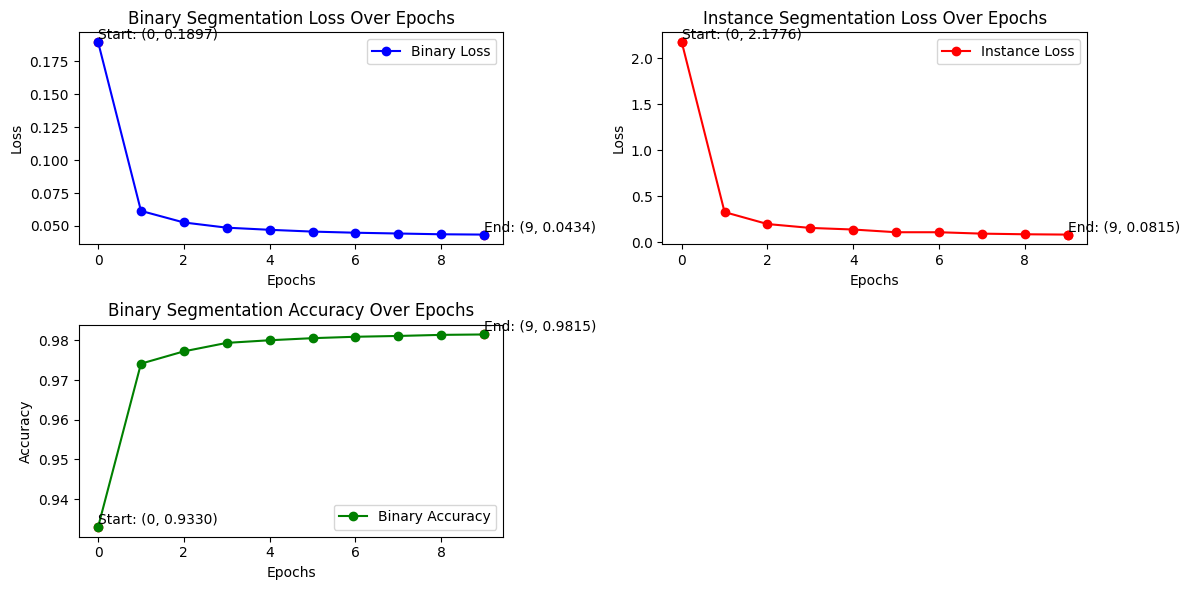

In [161]:


# Plot the training losses and accuracy over epochs
plt.figure(figsize=(12, 6))

# Plot Binary Segmentation Loss
plt.subplot(2, 2, 1)
plt.plot(range(NUM_EPOCHS), binary_losses_epoch, label="Binary Loss", color='b', marker='o')
plt.scatter([0, NUM_EPOCHS - 1], [binary_losses_epoch[0], binary_losses_epoch[-1]], color='r', marker='o')
plt.text(0, binary_losses_epoch[0], f'Start: (0, {binary_losses_epoch[0]:.4f})', verticalalignment='bottom')
plt.text(NUM_EPOCHS - 1, binary_losses_epoch[-1], f'End: ({NUM_EPOCHS - 1}, {binary_losses_epoch[-1]:.4f})', verticalalignment='bottom')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Binary Segmentation Loss Over Epochs')
plt.legend()

# Plot Instance Segmentation Loss
plt.subplot(2, 2, 2)
plt.plot(range(NUM_EPOCHS), instance_losses_epoch, label="Instance Loss", color='r', marker='o')
plt.scatter([0, NUM_EPOCHS - 1], [instance_losses_epoch[0], instance_losses_epoch[-1]], color='r', marker='o')
plt.text(0, instance_losses_epoch[0], f'Start: (0, {instance_losses_epoch[0]:.4f})', verticalalignment='bottom')
plt.text(NUM_EPOCHS - 1, instance_losses_epoch[-1], f'End: ({NUM_EPOCHS - 1}, {instance_losses_epoch[-1]:.4f})', verticalalignment='bottom')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Instance Segmentation Loss Over Epochs')
plt.legend()

# Plot Binary Segmentation Accuracy
plt.subplot(2, 2, 3)
plt.plot(range(NUM_EPOCHS), train_accuracies, label="Binary Accuracy", color='g', marker='o')
plt.scatter([0, NUM_EPOCHS - 1], [train_accuracies[0], train_accuracies[-1]], color='r', marker='o')
plt.text(0, train_accuracies[0], f'Start: (0, {train_accuracies[0]:.4f})', verticalalignment='bottom')
plt.text(NUM_EPOCHS - 1, train_accuracies[-1], f'End: ({NUM_EPOCHS - 1}, {train_accuracies[-1]:.4f})', verticalalignment='bottom')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Binary Segmentation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.savefig("combined_plots_with_start_end_values_on_marker.png")
plt.show()

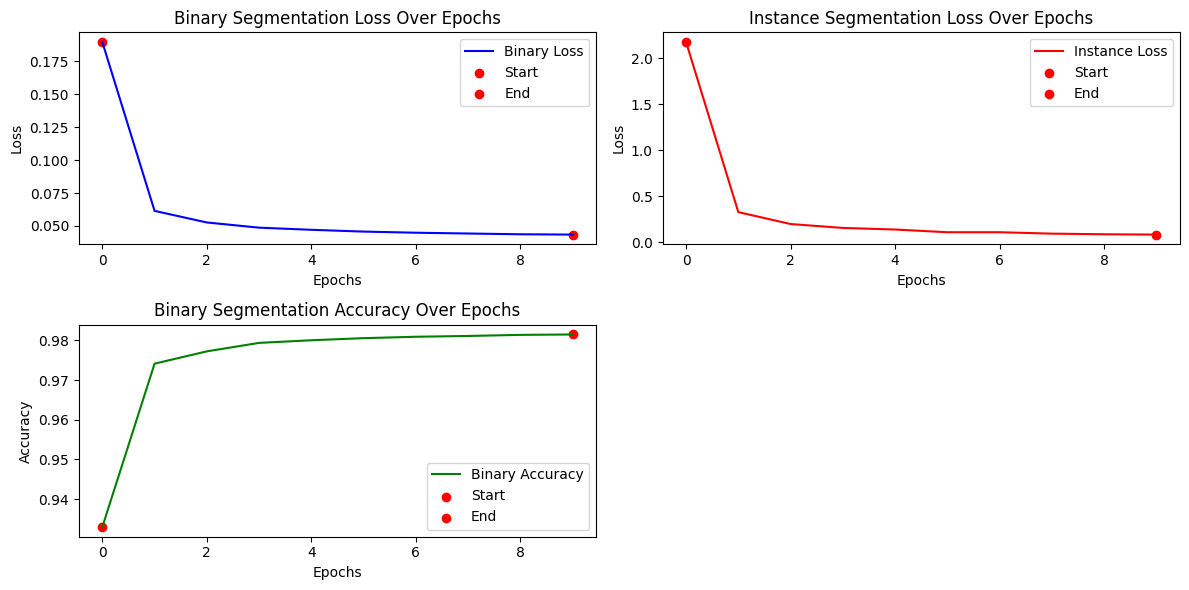

In [162]:


# Plot the training losses and accuracy over epochs
plt.figure(figsize=(12, 6))

# Plot Binary Segmentation Loss
plt.subplot(2, 2, 1)
plt.plot(range(NUM_EPOCHS), binary_losses_epoch, label="Binary Loss", color='b')
plt.scatter(0, binary_losses_epoch[0], color='r', marker='o', label='Start')
plt.scatter(NUM_EPOCHS - 1, binary_losses_epoch[-1], color='r', marker='o', label='End')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Binary Segmentation Loss Over Epochs')
plt.legend()

# Plot Instance Segmentation Loss
plt.subplot(2, 2, 2)
plt.plot(range(NUM_EPOCHS), instance_losses_epoch, label="Instance Loss", color='r')
plt.scatter(0, instance_losses_epoch[0], color='r', marker='o', label='Start')
plt.scatter(NUM_EPOCHS - 1, instance_losses_epoch[-1], color='r', marker='o', label='End')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Instance Segmentation Loss Over Epochs')
plt.legend()

# Plot Binary Segmentation Accuracy
plt.subplot(2, 2, 3)
plt.plot(range(NUM_EPOCHS), train_accuracies, label="Binary Accuracy", color='g')
plt.scatter(0, train_accuracies[0], color='r', marker='o', label='Start')
plt.scatter(NUM_EPOCHS - 1, train_accuracies[-1], color='r', marker='o', label='End')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Binary Segmentation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.savefig("combined_plots_with_start_end.png")
plt.show()


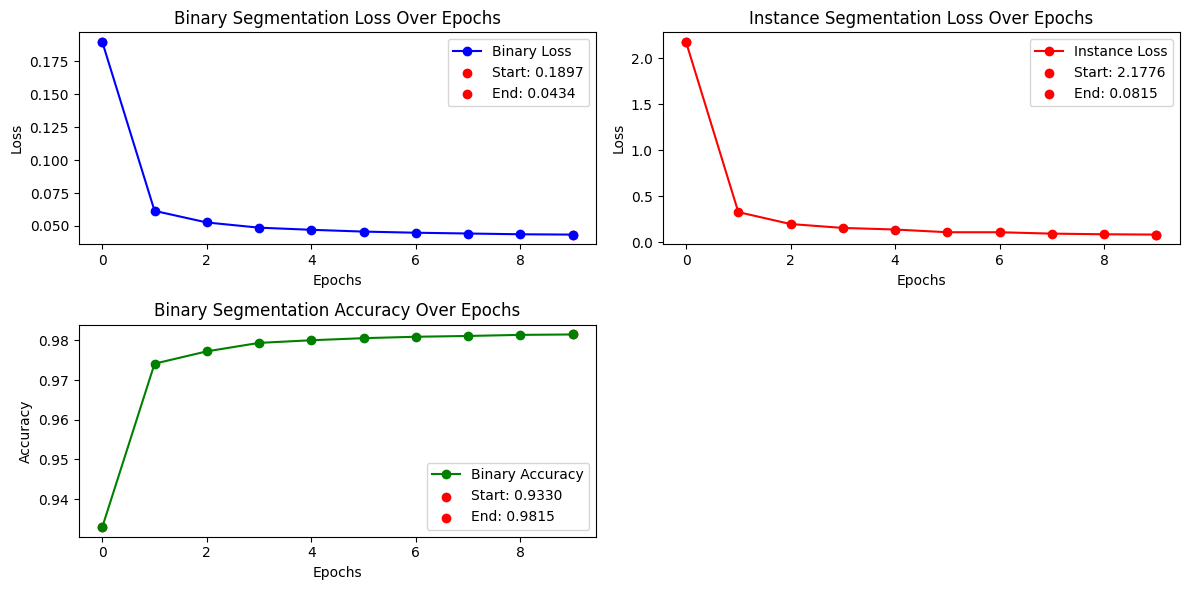

In [163]:

# Plot the training losses and accuracy over epochs
plt.figure(figsize=(12, 6))

# Plot Binary Segmentation Loss
plt.subplot(2, 2, 1)
plt.plot(range(NUM_EPOCHS), binary_losses_epoch, label="Binary Loss", color='b', marker='o')
plt.scatter(0, binary_losses_epoch[0], color='r', marker='o', label=f'Start: {binary_losses_epoch[0]:.4f}')
plt.scatter(NUM_EPOCHS - 1, binary_losses_epoch[-1], color='r', marker='o', label=f'End: {binary_losses_epoch[-1]:.4f}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Binary Segmentation Loss Over Epochs')
plt.legend()

# Plot Instance Segmentation Loss
plt.subplot(2, 2, 2)
plt.plot(range(NUM_EPOCHS), instance_losses_epoch, label="Instance Loss", color='r', marker='o')
plt.scatter(0, instance_losses_epoch[0], color='r', marker='o', label=f'Start: {instance_losses_epoch[0]:.4f}')
plt.scatter(NUM_EPOCHS - 1, instance_losses_epoch[-1], color='r', marker='o', label=f'End: {instance_losses_epoch[-1]:.4f}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Instance Segmentation Loss Over Epochs')
plt.legend()

# Plot Binary Segmentation Accuracy
plt.subplot(2, 2, 3)
plt.plot(range(NUM_EPOCHS), train_accuracies, label="Binary Accuracy", color='g', marker='o')
plt.scatter(0, train_accuracies[0], color='r', marker='o', label=f'Start: {train_accuracies[0]:.4f}')
plt.scatter(NUM_EPOCHS - 1, train_accuracies[-1], color='r', marker='o', label=f'End: {train_accuracies[-1]:.4f}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Binary Segmentation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.savefig("combined_plots_with_start_end_values.png")
plt.show()

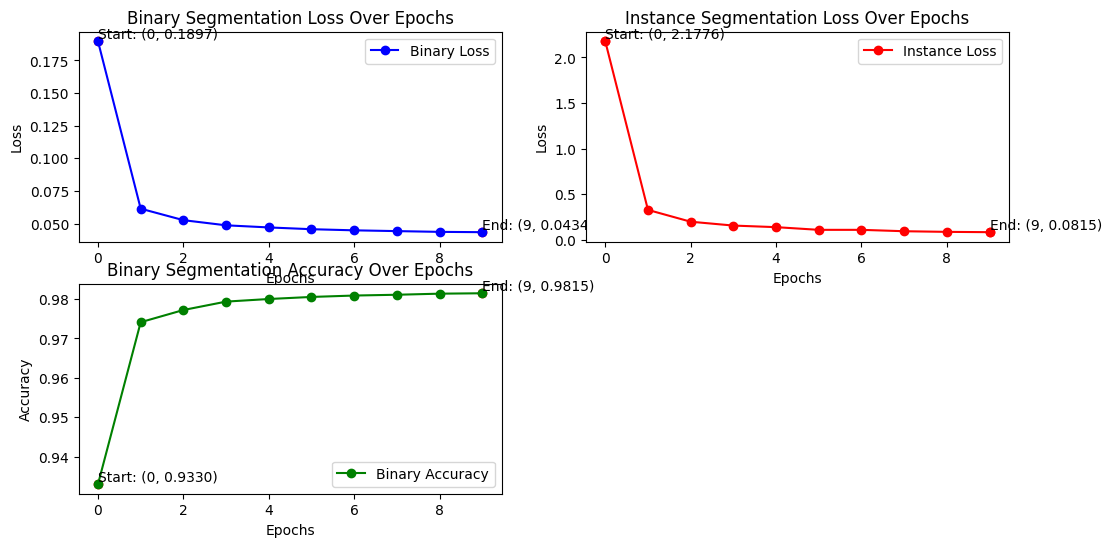

In [164]:

# Plot the training losses and accuracy over epochs
plt.figure(figsize=(12, 6))

# Plot Binary Segmentation Loss
plt.subplot(2, 2, 1)
plt.plot(range(NUM_EPOCHS), binary_losses_epoch, label="Binary Loss", color='b', marker='o')
plt.scatter([0, NUM_EPOCHS - 1], [binary_losses_epoch[0], binary_losses_epoch[-1]], color='r', marker='o')
plt.text(0, binary_losses_epoch[0], f'Start: (0, {binary_losses_epoch[0]:.4f})', verticalalignment='bottom')
plt.text(NUM_EPOCHS - 1, binary_losses_epoch[-1], f'End: ({NUM_EPOCHS - 1}, {binary_losses_epoch[-1]:.4f})', verticalalignment='bottom')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Binary Segmentation Loss Over Epochs')
plt.legend()

# Plot Instance Segmentation Loss
plt.subplot(2, 2, 2)
plt.plot(range(NUM_EPOCHS), instance_losses_epoch, label="Instance Loss", color='r', marker='o')
plt.scatter([0, NUM_EPOCHS - 1], [instance_losses_epoch[0], instance_losses_epoch[-1]], color='r', marker='o')
plt.text(0, instance_losses_epoch[0], f'Start: (0, {instance_losses_epoch[0]:.4f})', verticalalignment='bottom')
plt.text(NUM_EPOCHS - 1, instance_losses_epoch[-1], f'End: ({NUM_EPOCHS - 1}, {instance_losses_epoch[-1]:.4f})', verticalalignment='bottom')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Instance Segmentation Loss Over Epochs')
plt.legend()

# Plot Binary Segmentation Accuracy
plt.subplot(2, 2, 3)
plt.plot(range(NUM_EPOCHS), train_accuracies, label="Binary Accuracy", color='g', marker='o')
plt.scatter([0, NUM_EPOCHS - 1], [train_accuracies[0], train_accuracies[-1]], color='r', marker='o')
plt.text(0, train_accuracies[0], f'Start: (0, {train_accuracies[0]:.4f})', verticalalignment='bottom')
plt.text(NUM_EPOCHS - 1, train_accuracies[-1], f'End: ({NUM_EPOCHS - 1}, {train_accuracies[-1]:.4f})', verticalalignment='bottom')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Binary Segmentation Accuracy Over Epochs')
plt.legend()


In [165]:
torch.save(enet_model.state_dict(), "enet_new_model.pth")


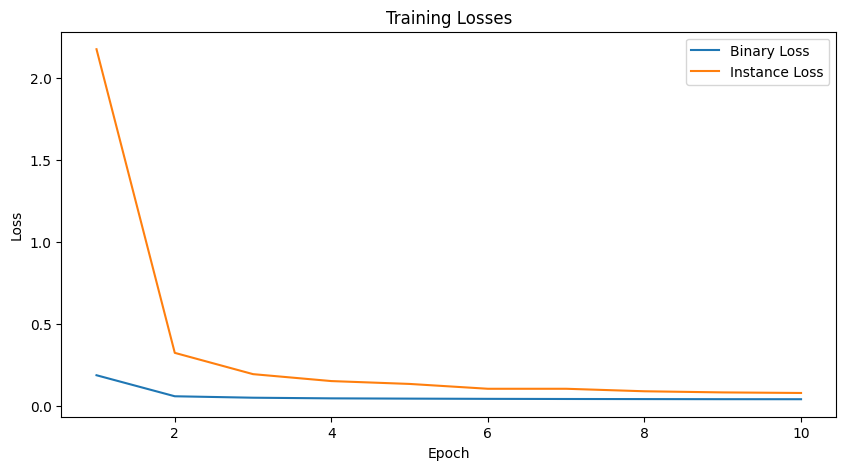

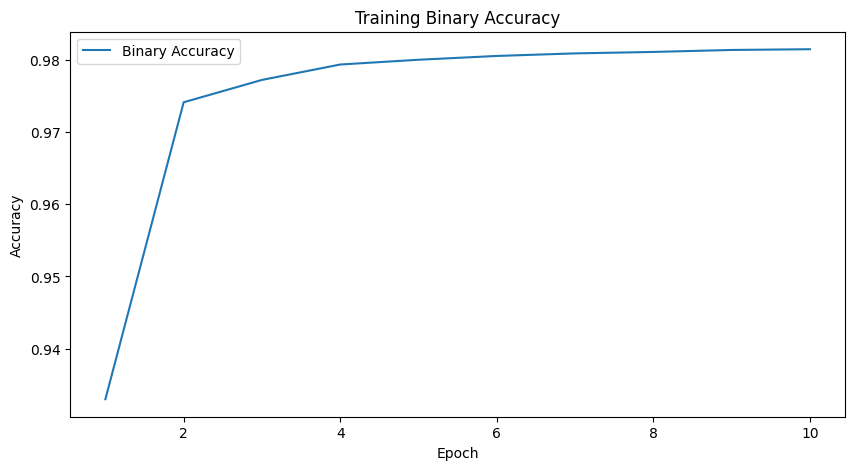

In [166]:
# Plotting training losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), binary_losses_epoch, label='Binary Loss')
plt.plot(range(1, NUM_EPOCHS + 1), instance_losses_epoch, label='Instance Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

# Plotting training accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Binary Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Binary Accuracy')
plt.legend()
plt.show()